<a href="https://colab.research.google.com/github/Aquib88raza/image-classification-ANKLE/blob/main/xgbmulticlass1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from keras.applications import MobileNetV2
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier  # Add XGBoost library
from sklearn.ensemble import VotingClassifier

In [29]:
# Definitions
classifiers_names = [
    "KNeighborsClassifier",
    "SVC",
    'MultinomialNB',
    "DecisionTreeClassifier",
    "RandomForestClassifier",
    "XGBClassifier"  # Add XGBoost
]

classifiers = [
    KNeighborsClassifier(),
    SVC(probability=True),
    MultinomialNB(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier()  # Add XGBoost
]

parameters = [
    {'n_neighbors': [3, 5, 7, 9, 11, 13]},  # KNeighborsClassifier
    {'C': [1, 10, 50, 70, 100], 'gamma':['scale', 'auto'], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'class_weight': [None, 'balanced']}, # SVC
    {'alpha': [0.1, 0.5, 1.0]},  # MultinomialNB
    {'max_depth': [None, 3, 5, 7, 10]},  # DecisionTreeClassifier
    {'n_estimators': [50, 100, 200, 300, 500], 'warm_start': [True, False], 'n_jobs':[None, 1, 2, 3]},  # RandomForestClassifier
    {  # XGBoost parameters
        'max_depth': [3, 5, 7],
        'learning_rate': [0.1, 0.01, 0.001],
        'n_estimators': [50, 100, 200],
        'gamma': [0, 1, 2],
        'subsample': [0.8, 0.9, 1.0]
    }
]

In [30]:
# Paths to dataset folders
base_path = "/content/drive/MyDrive/knee osteo 2"  # Change to your dataset path

# Define class labels for multi-class problem
class_labels = ["healthy", "ill", "minimal", "moderate"]

dataset_images_names = []
dataset_images = []
dataset_labels = []

for label in class_labels:
    label_path = os.path.join(base_path, label)
    for filename in os.listdir(label_path):
        if filename.endswith(".jpg"):
            filepath = os.path.join(label_path, filename)
            image = cv2.imread(filepath)

            if image is not None and not image.size == 0:
                size = (128, 128)
                image = cv2.resize(image, size, interpolation=cv2.INTER_AREA)
                dataset_images.append(image)
                dataset_labels.append(label)
            else:
                print(f"Error loading or resizing image: {filepath}")

# Convert labels to numerical values
class_to_idx = {class_labels[i]: i for i in range(len(class_labels))}
dataset_labels = [class_to_idx[label] for label in dataset_labels]

# Shuffle the dataset
combined_arrays = list(zip(dataset_images, dataset_labels))
random.shuffle(combined_arrays)
shuffled_images, shuffled_labels = zip(*combined_arrays)
dataset_images = np.array(shuffled_images)
dataset_labels = np.array(shuffled_labels)

# Apply LDA for feature extraction
lda = LDA(n_components=3)  # You can adjust the number of components as needed
dataset_features = lda.fit_transform(dataset_images.reshape(-1, 128 * 128 * 3), dataset_labels)
# Apply Min-Max scaling to the dataset
scaler = MinMaxScaler()
scaled_dataset_features = scaler.fit_transform(dataset_features)

In [31]:
best_models = []
acc_cross = []
var_cross = []
pred_reports = []
pred_cross = []
roc_curves = []
auc_scores = []

for i in range(len(classifiers)):
    model = classifiers[i]
    model_name = classifiers_names[i]
    param_grid = parameters[i]

    # Grid Search for best parameters of models in terms of accuracy
    best_model = GridSearchCV(model, param_grid, scoring='accuracy', cv=StratifiedKFold(n_splits=8))

    # Model Fitting
    best_model.fit(scaled_dataset_features, dataset_labels)
    best_models.append(best_model)

    # Checking the params
    params = best_model.get_params()
    print(f'{model_name} -> {params}')

    # SCORING
    cv_accuracy = cross_val_score(best_model.best_estimator_, scaled_dataset_features, dataset_labels, scoring='accuracy', cv=StratifiedKFold(n_splits=8))

    # ACCURACY
    print(f'{model_name} - Accuracy using cross-validation: {cv_accuracy.mean()*100.0} %')
    acc_cross.append(f'{cv_accuracy.mean()*100.0} %')

    # VARIANCE
    print(f'{model_name} - Variance using cross-validation: {cv_accuracy.var()*100.0} %')
    var_cross.append(f'{cv_accuracy.var()}')
    print()

    # PREDICTIONS
    cv_predict = cross_val_predict(best_model.best_estimator_, scaled_dataset_features, dataset_labels, cv=StratifiedKFold(n_splits=8))
    classes = class_labels
    pred_reports.append(classification_report(dataset_labels, cv_predict, target_names=classes))
    pred_cross.append(cv_predict)

    print(f'Done with classification: {model_name}')


KNeighborsClassifier -> {'cv': StratifiedKFold(n_splits=8, random_state=None, shuffle=False), 'error_score': nan, 'estimator__algorithm': 'auto', 'estimator__leaf_size': 30, 'estimator__metric': 'minkowski', 'estimator__metric_params': None, 'estimator__n_jobs': None, 'estimator__n_neighbors': 5, 'estimator__p': 2, 'estimator__weights': 'uniform', 'estimator': KNeighborsClassifier(), 'n_jobs': None, 'param_grid': {'n_neighbors': [3, 5, 7, 9, 11, 13]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': 'accuracy', 'verbose': 0}
KNeighborsClassifier - Accuracy using cross-validation: 94.25105485232066 %
KNeighborsClassifier - Variance using cross-validation: 0.015105084655236856 %

Done with classification: KNeighborsClassifier
SVC -> {'cv': StratifiedKFold(n_splits=8, random_state=None, shuffle=False), 'error_score': nan, 'estimator__C': 1.0, 'estimator__break_ties': False, 'estimator__cache_size': 200, 'estimator__class_weight': None, 'estimator__coef0':

In [37]:
class_counts = {label: np.sum(dataset_labels == class_to_idx[label]) for label in class_labels}
total_samples = len(dataset_labels)

for label, count in class_counts.items():
    print(f"Class '{label}': {count} samples")

print(f"Total number of samples: {total_samples}")


Class 'healthy': 474 samples
Class 'ill': 474 samples
Class 'minimal': 474 samples
Class 'moderate': 474 samples
Total number of samples: 1896


Best parameters for KNeighborsClassifier: {'n_neighbors': 9}
Model parameters for KNeighborsClassifier -> {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 9, 'p': 2, 'weights': 'uniform'}
Accuracy using cross-validation: 94.25105485232066 %
Variance using cross-validation: 0.00015105084655236856


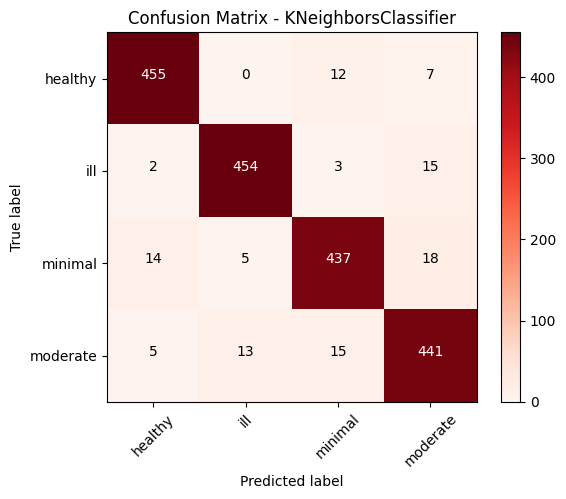

Classification Report - KNeighborsClassifier:
              precision    recall  f1-score   support

     healthy       0.94      0.94      0.94       474
         ill       0.95      0.94      0.95       474
     minimal       0.92      0.91      0.92       474
    moderate       0.90      0.92      0.91       474

    accuracy                           0.93      1896
   macro avg       0.93      0.93      0.93      1896
weighted avg       0.93      0.93      0.93      1896



Best parameters for SVC: {'C': 10, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}
Model parameters for SVC -> {'C': 10, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Accuracy using cross-validation: 94.25105485232068 %
Variance using cross-validation: 0.00021336279798465343


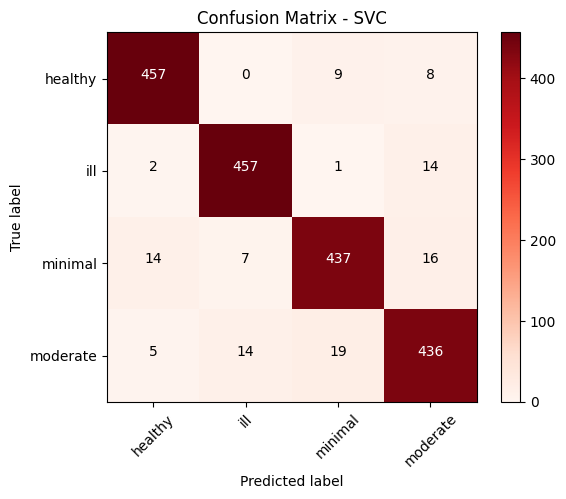

Classification Report - SVC:
              precision    recall  f1-score   support

     healthy       0.94      0.94      0.94       474
         ill       0.95      0.94      0.95       474
     minimal       0.92      0.91      0.92       474
    moderate       0.90      0.92      0.91       474

    accuracy                           0.93      1896
   macro avg       0.93      0.93      0.93      1896
weighted avg       0.93      0.93      0.93      1896



Best parameters for MultinomialNB: {'alpha': 1.0}
Model parameters for MultinomialNB -> {'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': 'warn'}
Accuracy using cross-validation: 92.03586497890296 %
Variance using cross-validation: 0.00012657115134682848


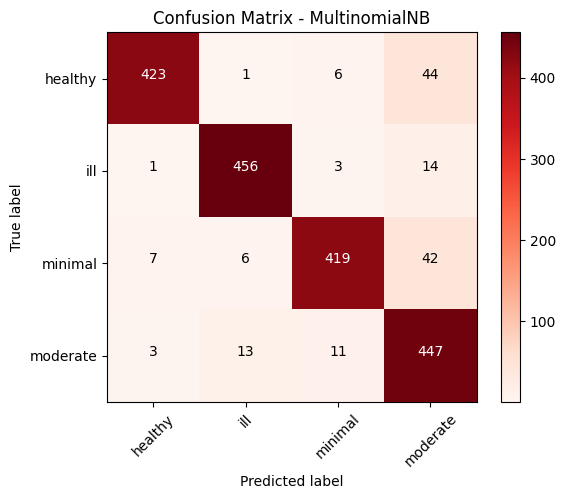

Classification Report - MultinomialNB:
              precision    recall  f1-score   support

     healthy       0.94      0.94      0.94       474
         ill       0.95      0.94      0.95       474
     minimal       0.92      0.91      0.92       474
    moderate       0.90      0.92      0.91       474

    accuracy                           0.93      1896
   macro avg       0.93      0.93      0.93      1896
weighted avg       0.93      0.93      0.93      1896



Best parameters for DecisionTreeClassifier: {'max_depth': 3}
Model parameters for DecisionTreeClassifier -> {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
Accuracy using cross-validation: 92.72151898734178 %
Variance using cross-validation: 0.00016356887250974753


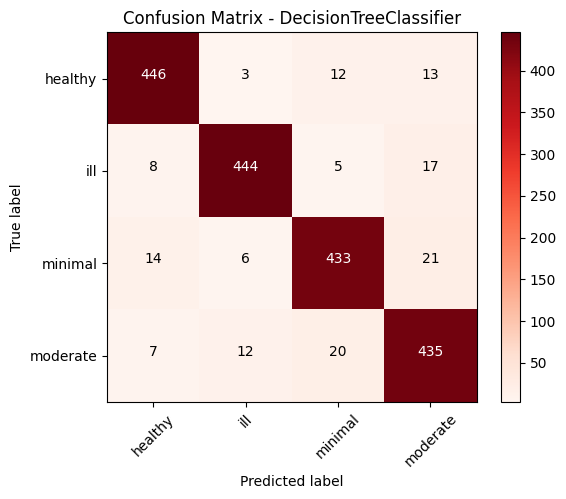

Classification Report - DecisionTreeClassifier:
              precision    recall  f1-score   support

     healthy       0.94      0.94      0.94       474
         ill       0.95      0.94      0.95       474
     minimal       0.92      0.91      0.92       474
    moderate       0.90      0.92      0.91       474

    accuracy                           0.93      1896
   macro avg       0.93      0.93      0.93      1896
weighted avg       0.93      0.93      0.93      1896



Best parameters for RandomForestClassifier: {'n_estimators': 50, 'n_jobs': 2, 'warm_start': False}
Model parameters for RandomForestClassifier -> {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': 2, 'oob_score': False, 'random_state': None, 'verbose': 0, '

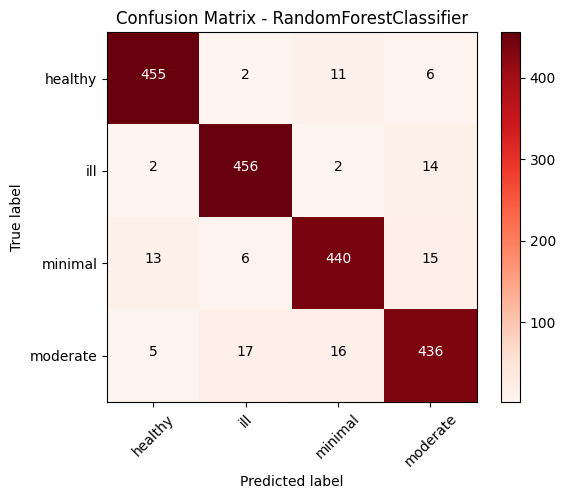

Classification Report - RandomForestClassifier:
              precision    recall  f1-score   support

     healthy       0.94      0.94      0.94       474
         ill       0.95      0.94      0.95       474
     minimal       0.92      0.91      0.92       474
    moderate       0.90      0.92      0.91       474

    accuracy                           0.93      1896
   macro avg       0.93      0.93      0.93      1896
weighted avg       0.93      0.93      0.93      1896



Best parameters for XGBClassifier: {'gamma': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1.0}
Model parameters for XGBClassifier -> {'objective': 'multi:softprob', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 1, 'grow_policy': None, 'importance_type': None, 'intera

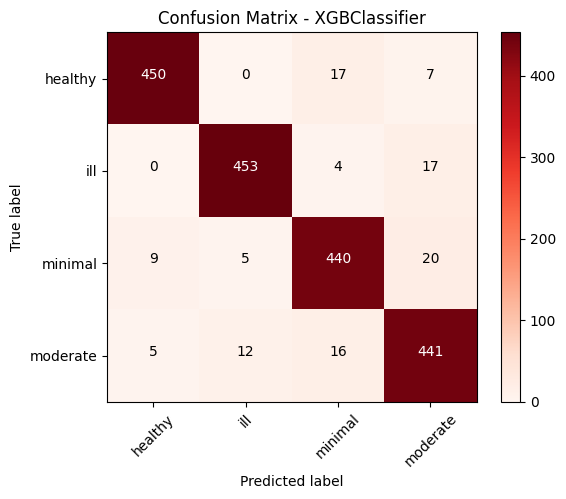

Classification Report - XGBClassifier:
              precision    recall  f1-score   support

     healthy       0.94      0.94      0.94       474
         ill       0.95      0.94      0.95       474
     minimal       0.92      0.91      0.92       474
    moderate       0.90      0.92      0.91       474

    accuracy                           0.93      1896
   macro avg       0.93      0.93      0.93      1896
weighted avg       0.93      0.93      0.93      1896





In [40]:
# PARAMETERS, ACCURACIES, VARIANCES, CONFUSION MATRICES, CLASSIFICATION REPORT

for i in range(len(best_models)):
    # name
    model_name = classifiers_names[i]

    # Checking the best parameters
    best_params = best_models[i].best_params_
    print(f'Best parameters for {model_name}: {best_params}')

    # Checking the params of the best model
    params = best_models[i].best_estimator_.get_params()
    print(f'Model parameters for {model_name} -> {params}')

    # ACCURACY
    print(f'Accuracy using cross-validation: {acc_cross[i]}')

    # VARIANCE
    print(f'Variance using cross-validation: {var_cross[i]}')

    # CONFUSION MATRICES
    cm = confusion_matrix(dataset_labels, pred_cross[i])

    # Create a custom red colormap
    custom_cmap = plt.cm.Reds  # Use Reds colormap for red color

    plt.imshow(cm, interpolation='nearest', cmap=custom_cmap)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.colorbar()

    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Annotate the confusion matrix with numbers
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.show()

    # CLASSIFICATION REPORT
    print(f'Classification Report - {model_name}:')
    print(pred_reports[i])

    print()
    print()


In [45]:
# Create a list of (model_name, model) tuples for the VotingClassifier
ensemble_models = []

for i in range(len(best_models)):
    model_name = classifiers_names[i]
    model = best_models[i].best_estimator_
    ensemble_models.append((model_name, model))

# Create the VotingClassifier
ensemble = VotingClassifier(estimators=ensemble_models, voting='soft')  # You can choose 'soft' or 'hard' voting

# Fit the ensemble model on your dataset
ensemble.fit(scaled_dataset_features, dataset_labels)

# Make predictions using the ensemble model
ensemble_predictions = cross_val_predict(ensemble, scaled_dataset_features, dataset_labels, cv=StratifiedKFold(n_splits=8))

# Calculate the accuracy of the ensemble model
ensemble_accuracy = accuracy_score(dataset_labels, ensemble_predictions)
print(f'Ensemble Model - Accuracy using cross-validation: {ensemble_accuracy * 100.0} %')

Ensemble Model - Accuracy using cross-validation: 93.9873417721519 %


In [46]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, classification_report

# Create a list of all your trained models
all_models = [
    ('KNeighborsClassifier', best_models[0].best_estimator_),
    ('SVC', best_models[1].best_estimator_),
    ('MultinomialNB', best_models[2].best_estimator_),
    ('DecisionTreeClassifier', best_models[3].best_estimator_),
    ('RandomForestClassifier', best_models[4].best_estimator_),
    ('XGBClassifier', best_models[5].best_estimator_),
    # Add more models here if you have more
]

# Create a Voting Classifier with all the models
ensemble = VotingClassifier(estimators=all_models, voting='soft')  # You can choose 'soft' or 'hard' voting

# Make predictions using the ensemble model
ensemble_predictions = cross_val_predict(ensemble, scaled_dataset_features, dataset_labels, cv=StratifiedKFold(n_splits=8))

# Calculate the accuracy of the ensemble model
ensemble_accuracy = accuracy_score(dataset_labels, ensemble_predictions)
print(f'Ensemble Model - Accuracy using cross-validation: {ensemble_accuracy * 100.0} %')

# Generate other evaluation metrics (classification report, confusion matrix, etc.) for the ensemble model as needed
ensemble_classification_report = classification_report(dataset_labels, ensemble_predictions, target_names=class_labels)
print('Ensemble Model - Classification Report:')
print(ensemble_classification_report)


Ensemble Model - Accuracy using cross-validation: 94.14556962025317 %
Ensemble Model - Classification Report:
              precision    recall  f1-score   support

     healthy       0.96      0.96      0.96       474
         ill       0.95      0.96      0.95       474
     minimal       0.93      0.92      0.93       474
    moderate       0.92      0.93      0.92       474

    accuracy                           0.94      1896
   macro avg       0.94      0.94      0.94      1896
weighted avg       0.94      0.94      0.94      1896



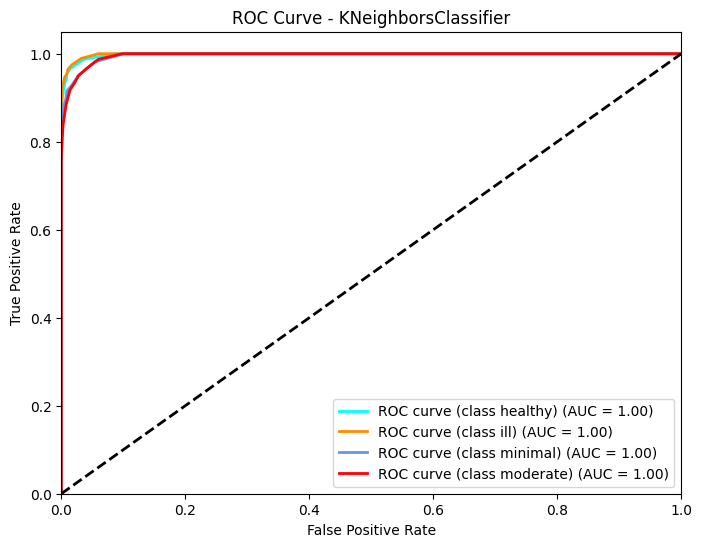

KNeighborsClassifier - AUC (class healthy): 1.00
KNeighborsClassifier - AUC (class ill): 1.00
KNeighborsClassifier - AUC (class minimal): 1.00
KNeighborsClassifier - AUC (class moderate): 1.00



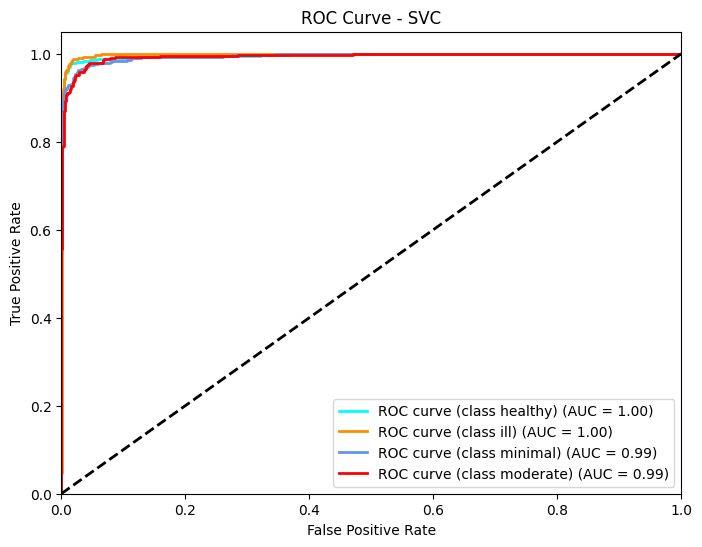

SVC - AUC (class healthy): 1.00
SVC - AUC (class ill): 1.00
SVC - AUC (class minimal): 0.99
SVC - AUC (class moderate): 0.99



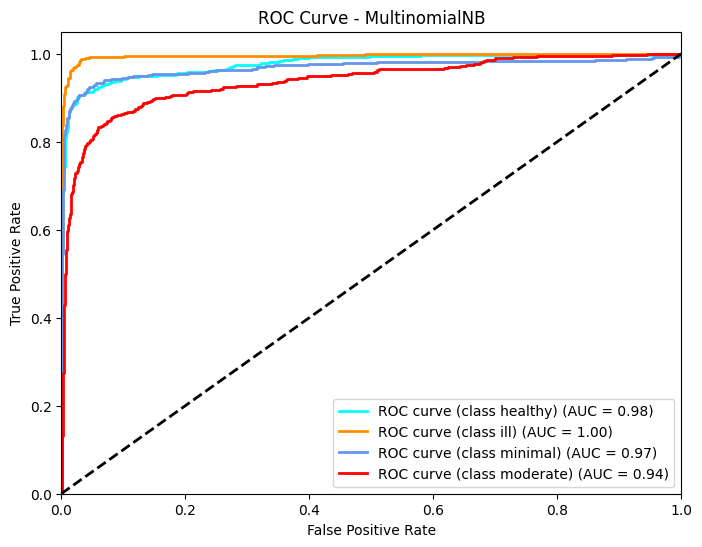

MultinomialNB - AUC (class healthy): 0.98
MultinomialNB - AUC (class ill): 1.00
MultinomialNB - AUC (class minimal): 0.97
MultinomialNB - AUC (class moderate): 0.94



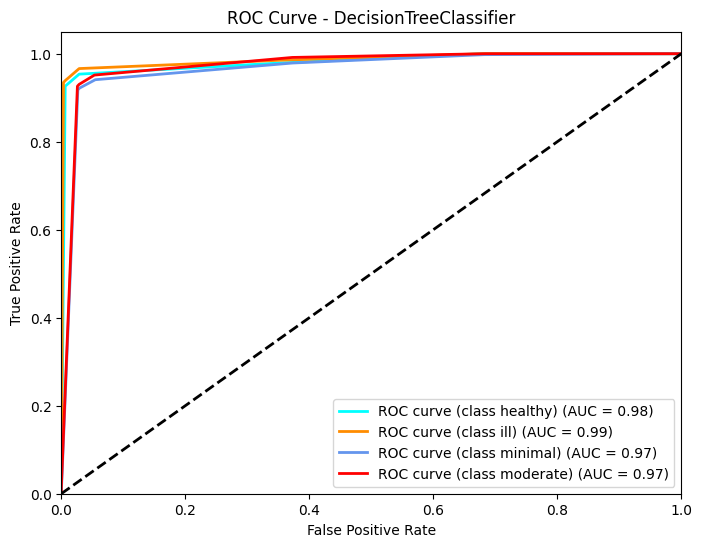

DecisionTreeClassifier - AUC (class healthy): 0.98
DecisionTreeClassifier - AUC (class ill): 0.99
DecisionTreeClassifier - AUC (class minimal): 0.97
DecisionTreeClassifier - AUC (class moderate): 0.97



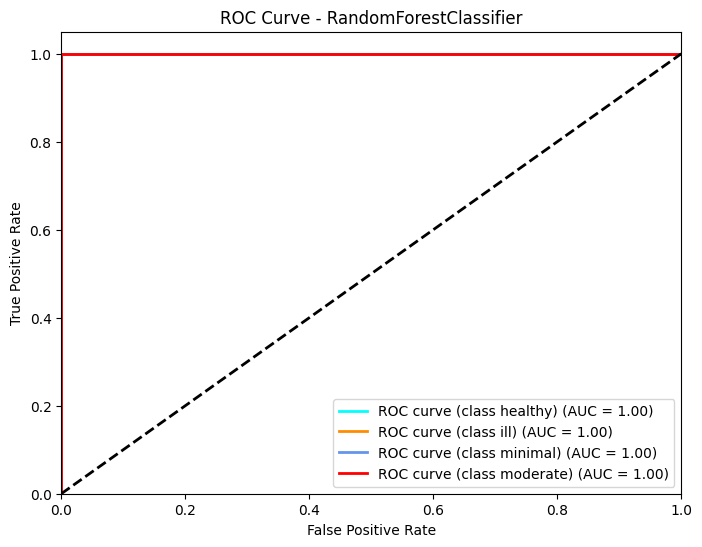

RandomForestClassifier - AUC (class healthy): 1.00
RandomForestClassifier - AUC (class ill): 1.00
RandomForestClassifier - AUC (class minimal): 1.00
RandomForestClassifier - AUC (class moderate): 1.00



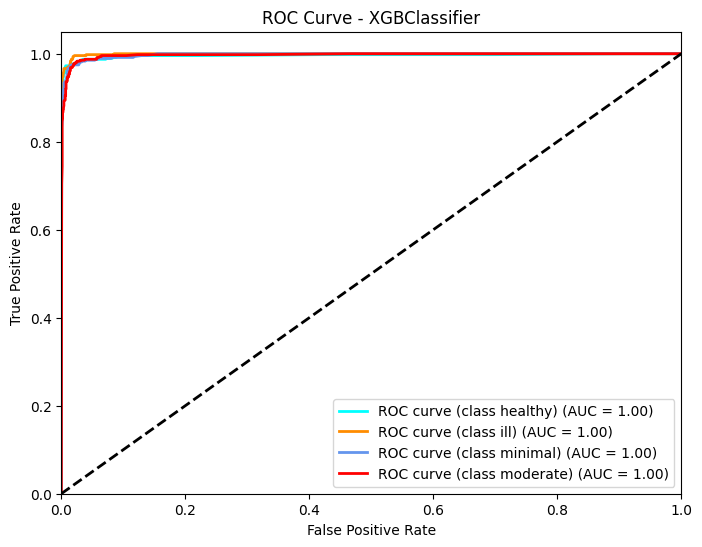

XGBClassifier - AUC (class healthy): 1.00
XGBClassifier - AUC (class ill): 1.00
XGBClassifier - AUC (class minimal): 1.00
XGBClassifier - AUC (class moderate): 1.00



In [41]:
# @title ROC CURVES AND AUC SCORES

for i in range(len(best_models)):
    model_name = classifiers_names[i]

    # Get the best model from GridSearchCV
    best_model = best_models[i].best_estimator_

    # Compute ROC curve and AUC for each class
    y_scores = best_model.predict_proba(scaled_dataset_features)
    n_classes = len(class_labels)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for j in range(n_classes):
        fpr[j], tpr[j], _ = roc_curve(np.array(dataset_labels) == j, y_scores[:, j])
        roc_auc[j] = auc(fpr[j], tpr[j])

    # Plot ROC curves for each class
    plt.figure(figsize=(8, 6))
    colors = ['aqua', 'darkorange', 'cornflowerblue', 'red']
    for j, color in zip(range(n_classes), colors):
        plt.plot(fpr[j], tpr[j], color=color, lw=2, label=f'ROC curve (class {class_labels[j]}) (AUC = {roc_auc[j]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC scores
    for j in range(n_classes):
        print(f'{model_name} - AUC (class {class_labels[j]}): {roc_auc[j]:.2f}')

    print()


In [42]:
# @title SENSITIVITY (True Positive Rate) AND SPECIFICITY (True Negative Rate)

for i in range(len(best_models)):
    model_name = classifiers_names[i]

    # Get the best model from GridSearchCV
    best_model = best_models[i].best_estimator_

    # Compute ROC curve and AUC for each class
    y_scores = best_model.predict_proba(scaled_dataset_features)
    n_classes = len(class_labels)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for j in range(n_classes):
        fpr[j], tpr[j], _ = roc_curve(np.array(dataset_labels) == j, y_scores[:, j])
        roc_auc[j] = auc(fpr[j], tpr[j])

    # Calculate sensitivity (True Positive Rate) and specificity (True Negative Rate)
    sensitivity = dict()
    specificity = dict()

    for j in range(n_classes):
        # Create binary labels for the current class
        binary_labels = np.array(dataset_labels) == j

        # Get predicted labels for the current class
        predicted_labels = best_model.predict(scaled_dataset_features)

        # Calculate confusion matrix for the current class
        tn, fp, fn, tp = confusion_matrix(binary_labels, predicted_labels == j).ravel()

        # Calculate sensitivity and specificity for the current class
        sensitivity[j] = tp / (tp + fn)
        specificity[j] = tn / (tn + fp)

    # Print sensitivity and specificity for each class
    for j in range(n_classes):
        print(f'{model_name} - Sensitivity (class {class_labels[j]}): {sensitivity[j]:.2f}')
        print(f'{model_name} - Specificity (class {class_labels[j]}): {specificity[j]:.2f}')

    print()


KNeighborsClassifier - Sensitivity (class healthy): 0.97
KNeighborsClassifier - Specificity (class healthy): 0.98
KNeighborsClassifier - Sensitivity (class ill): 0.96
KNeighborsClassifier - Specificity (class ill): 0.99
KNeighborsClassifier - Sensitivity (class minimal): 0.92
KNeighborsClassifier - Specificity (class minimal): 0.98
KNeighborsClassifier - Sensitivity (class moderate): 0.94
KNeighborsClassifier - Specificity (class moderate): 0.97

SVC - Sensitivity (class healthy): 0.97
SVC - Specificity (class healthy): 0.99
SVC - Sensitivity (class ill): 0.97
SVC - Specificity (class ill): 0.99
SVC - Sensitivity (class minimal): 0.93
SVC - Specificity (class minimal): 0.98
SVC - Sensitivity (class moderate): 0.94
SVC - Specificity (class moderate): 0.98

MultinomialNB - Sensitivity (class healthy): 0.89
MultinomialNB - Specificity (class healthy): 0.99
MultinomialNB - Sensitivity (class ill): 0.96
MultinomialNB - Specificity (class ill): 0.99
MultinomialNB - Sensitivity (class minimal

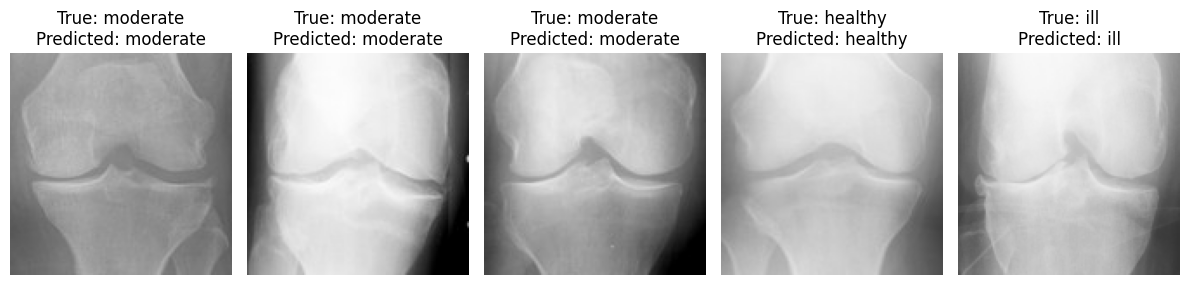

In [43]:
import math

# Define the number of rows and columns for the grid layout
num_rows = 1  # Set the number of rows to 1
num_cols = 5  # Adjust the number of columns as needed

num_images_to_display = num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 3))

for i in range(num_images_to_display):
    # Choose a random index
    random_index = random.randint(0, len(dataset_labels) - 1)
    random_image = dataset_images[random_index]
    true_label = class_labels[dataset_labels[random_index]]

    # Predict the class label for the random image
    predicted_label = class_labels[best_model.predict([scaled_dataset_features[random_index]])[0]]

    # Display the random image and its prediction in the current subplot
    axes[i].imshow(random_image)
    axes[i].set_title(f'True: {true_label}\nPredicted: {predicted_label}')
    axes[i].axis('off')

# Adjust spacing between subplots
plt.tight_layout()
plt.show()


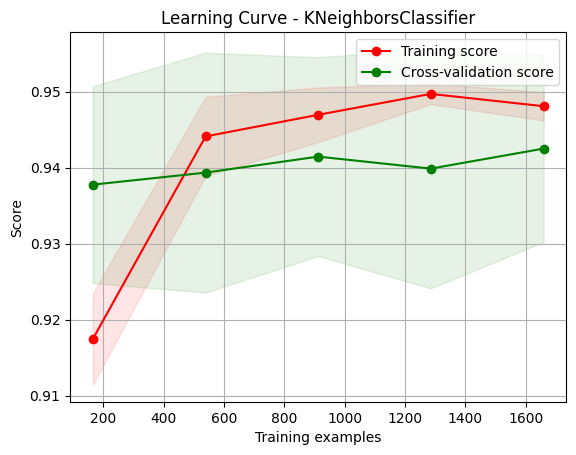

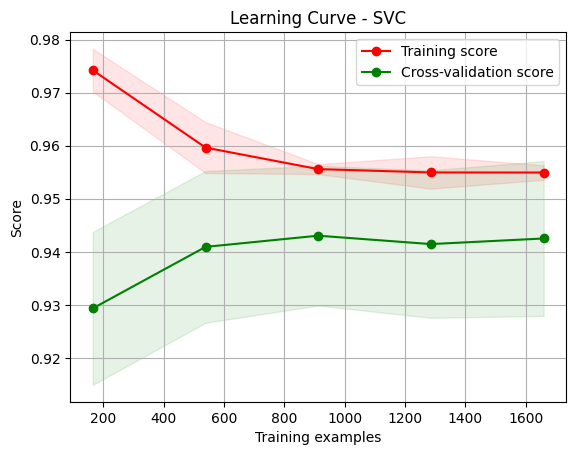

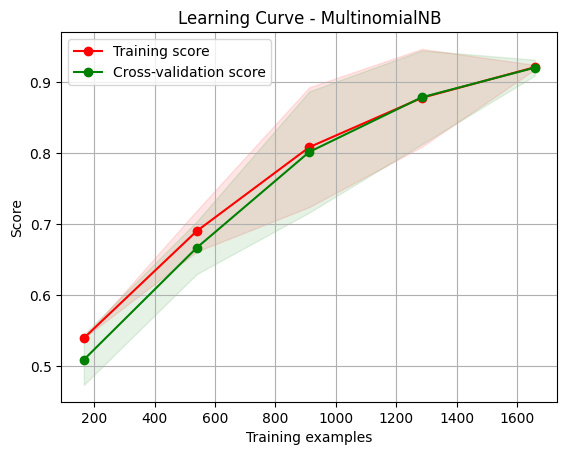

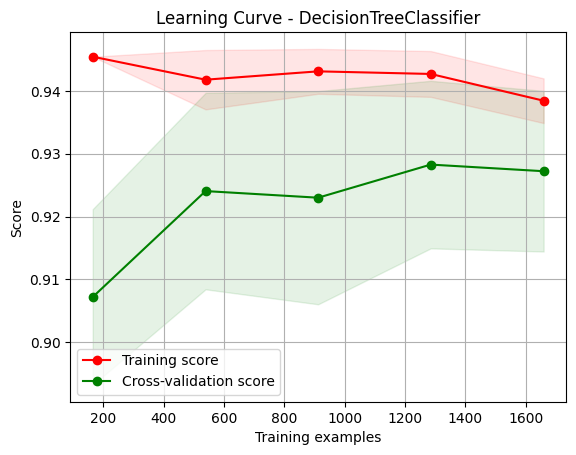

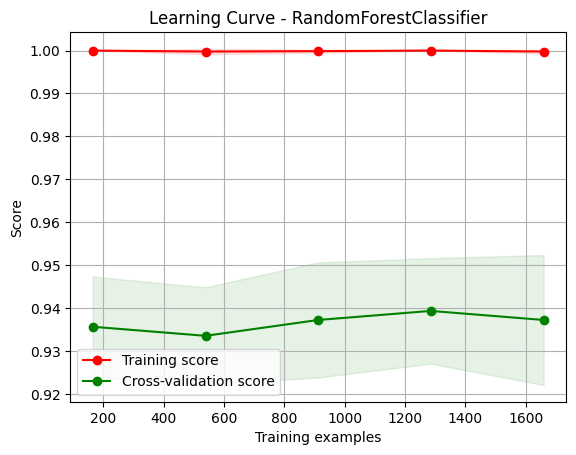

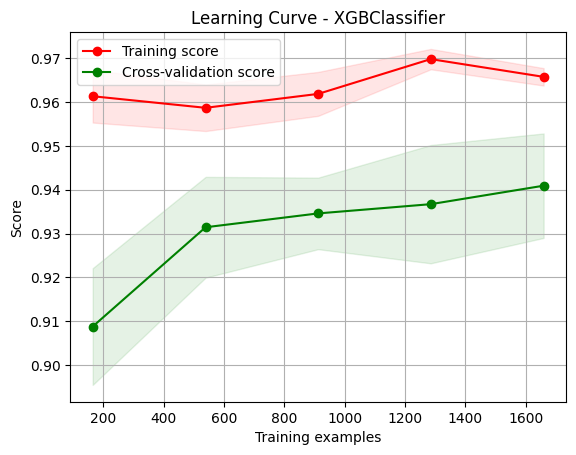

In [36]:
from sklearn.model_selection import learning_curve

# Define a function to plot learning curves
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Now, for each classifier, you can plot the learning curve
for i in range(len(best_models)):
    model = best_models[i].best_estimator_
    model_name = classifiers_names[i]

    title = f"Learning Curve - {model_name}"
    plot_learning_curve(model, title, scaled_dataset_features, dataset_labels, cv=StratifiedKFold(n_splits=8))
    plt.show()

In [13]:
# Initialize MobileNetV2 for feature extraction with additional layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add custom layers on top of MobileNetV2
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1012, activation='relu')(x)  # Add more layers if needed
x = Dropout(0.5)(x)  # Add dropout for regularization

# Define class labels for multi-class problem
class_labels = ["healthy", "ill", "minimal", "moderate"]

# Adjust the output layer based on the number of classes
predictions = Dense(len(class_labels), activation='softmax')(x)

# Create the new model
model = Model(inputs=base_model.input, outputs=predictions)

# Set MobileNetV2 layers as non-trainable (optional)
for layer in base_model.layers:
    layer.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
from google.colab import drive
drive.mount('/content/drive')